In [1]:
import torchvision
import torch
from torchvision import transforms
from tqdm.auto import tqdm
import random
import numpy as np
from models import vgg,layers
from torchvision.utils import _log_api_usage_once
import sys

sys.path.append("../")

def manual_seed(seed):
    np.random.seed(seed) #1
    random.seed(seed) #2
    torch.manual_seed(seed) #3
    torch.cuda.manual_seed(seed) #4.1
    torch.cuda.manual_seed_all(seed) #4.2
    torch.backends.cudnn.benchmark = False #5 
    torch.backends.cudnn.deterministic = True #6

manual_seed(42)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
bias_option = False

pre_vgg16 = vgg.vgg16(bias=bias_option)

In [4]:
print(pre_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

weight parameter 변경하기

In [5]:
# checkpoint = torch.load("./checkpoint/vgg16_adam_5e-05_64_False.pth")
checkpoint = torch.load("./checkpoint/adam_5e-05_64_False_224.pth")
# print(checkpoint['model_state_dict'])
pre_vgg16.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Parameter overwrite

In [6]:
# with torch.no_grad():
#     pre_weight = pre_vgg16.features[0].weight.data
#     print(pre_weight.shape, type(pre_weight))
#     zero_tensor = torch.zeros((64,1,3,3))
#     new_weight = torch.concat([pre_weight, zero_tensor], dim=1)
#     print(new_weight.shape)
#     new_parameter = torch.nn.Parameter(new_weight)
#     print(new_parameter.shape)
#     new_layer = torch.nn.Conv2d(4,64,3,1,1)
#     new_layer.weight = new_parameter
#     pre_vgg16.features[0] = new_layer
#     print(pre_vgg16.features[0].weight.data.shape)
#     print(pre_vgg16)

pre_vgg와 Float,Int model 구조 확인

In [7]:
for name, module in pre_vgg16.named_modules():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        # print(type(module))
        print(name)
        # print(module.weight().int_repr())

print("----------------------------------------------------------")
int_model = vgg.int_vgg16(bias=bias_option)
for name, module in int_model.named_modules():
    if isinstance(module, layers.IntConv2d) or isinstance(module, layers.IntLinear):
        # print(type(module))
        print(name)
        # print(module.weight().int_repr())

features.0
features.2
features.5
features.7
features.10
features.12
features.14
features.17
features.19
features.21
features.24
features.26
features.28
classifier.0
classifier.3
classifier.6
----------------------------------------------------------
features.0
features.2
features.5
features.7
features.10
features.12
features.14
features.17
features.19
features.21
features.24
features.26
features.28
classifier.0
classifier.2
classifier.4


In [8]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomCrop(224,padding=16),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std= (0.2675, 0.2565, 0.2761)),
])

test_transform = transforms.Compose([
     transforms.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.5071, 0.4867, 0.4408), std= (0.2675, 0.2565, 0.2761)),
])

# train_data = torchvision.datasets.CIFAR100(root="./dataset", train=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
#                                           shuffle=True,pin_memory=True,num_workers=4)
val_data = torchvision.datasets.CIFAR100(root="./dataset", train=False, transform=test_transform)
# val_loader = torch.utils.data.DataLoader(val_data, batch_size=32,
#                                           shuffle=False,pin_memory=True,num_workers=4)
# val_data = torchvision.datasets.ImageNet(root="./dataset/ImageNet", split='val', transform=test_transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32,
                                          shuffle=False,pin_memory=True,num_workers=4)


In [9]:
next_data = next(iter(val_loader))[0]
print(next_data.shape, next_data.max(), next_data.min())
imgs = torch.cat([next_data, torch.zeros((next_data.size(0),1,224,224))], dim=1)
print(imgs.shape)

torch.Size([32, 3, 224, 224]) tensor(1.) tensor(0.)
torch.Size([32, 4, 224, 224])


In [10]:
pre_vgg16.eval()
pre_vgg16.cuda()
def validate(model, test_loader, num_calib=None, cpu_device=False):
    model.eval()
    val_acc = 0
    with torch.no_grad():
        for i,data in enumerate(tqdm(test_loader,leave=True)):
            imgs = torch.cat([data[0], torch.zeros((data[0].size(0),1,224,224))], 1)
            if cpu_device:
                target = data[1]
            else:
                imgs, target = imgs.to(device), data[1].to(device)
            output = model(imgs)

            _, preds = torch.max(output.data, 1)
            val_acc += (preds==target).sum().item()
            if num_calib and (i > num_calib):
                break

    val_acc = 100. * val_acc/len(test_loader.dataset)

    return val_acc


In [11]:
start_acc = validate(pre_vgg16, val_loader)
pre_vgg16.to('cpu')
print(f"START  ACC {start_acc:.2f}")

100%|██████████| 313/313 [00:17<00:00, 18.39it/s]


START  ACC 37.10


## Float 모델에 실험 해보기    
NHWC 차원에서 동일한 정확도가 나오는지

In [12]:
float_model = vgg.float_vgg16(bias=bias_option) 

# bias 가 없는 모델 사용함
with torch.no_grad():
    conv_list = [0,2,5,7,10,12,14,17,19,21,24,26,28]

    for i in conv_list:
        pre_weight = pre_vgg16.features[i].weight.data.contiguous()
        print(f"{i} \nconv pre_weight shape : {pre_weight.shape} {pre_weight.stride()}")
        # convert_channel = pre_weight.to(memory_format=torch.channels_last)
        # print(f"convert channel last {convert_channel.shape} {convert_channel.stride()}")

        # convert_channel = convert_channel.permute(0,2,3,1).to(memory_format=torch.channels_last)
        # print(f"{convert_channel.shape} {convert_channel.stride()}")

        float_model.features[i].weight = pre_weight.permute(0,2,3,1).contiguous()
        print(f"after_weight shape : {float_model.features[i].weight.shape}, {(float_model.features[i].weight.stride())}")
        if bias_option:
            pre_bias = pre_vgg16.features[i].bias.data.contiguous()
            print(f"bias shape : {pre_vgg16.features[i].bias.shape}")
            
            float_model.features[i].bias = pre_bias.contiguous()
            print(torch.equal(pre_weight, float_model.features[i].weight.permute(0,3,1,2)))
        # print()

    linear_list = [(0,0), (3,2), (6,4)]

    for p_i, int_i in linear_list:
        pre_weight = pre_vgg16.classifier[p_i].weight.data
        print(f"{p_i} \nlinaer pre_weight shape : {pre_weight.shape} {pre_weight.stride()}")
        
        float_model.classifier[int_i].weight = pre_weight.permute(1,0).contiguous()
        print(f"after_weight shape : {float_model.classifier[int_i].weight.shape} {float_model.classifier[int_i].weight.stride()}")
        
        if bias_option:
            pre_bias = pre_vgg16.classifier[p_i].bias.data
            print(f"linaer pre_bias shape : {pre_bias.shape} {pre_bias.stride()}")
            
            float_model.classifier[int_i].bias = pre_bias.contiguous()
            print(f"after_bias shape : {float_model.classifier[int_i].bias.shape} {float_model.classifier[int_i].bias.stride()}\n")


0 
conv pre_weight shape : torch.Size([64, 4, 3, 3]) (36, 9, 3, 1)
after_weight shape : torch.Size([64, 3, 3, 4]), (36, 12, 4, 1)
2 
conv pre_weight shape : torch.Size([64, 64, 3, 3]) (576, 9, 3, 1)
after_weight shape : torch.Size([64, 3, 3, 64]), (576, 192, 64, 1)
5 
conv pre_weight shape : torch.Size([128, 64, 3, 3]) (576, 9, 3, 1)
after_weight shape : torch.Size([128, 3, 3, 64]), (576, 192, 64, 1)
7 
conv pre_weight shape : torch.Size([128, 128, 3, 3]) (1152, 9, 3, 1)
after_weight shape : torch.Size([128, 3, 3, 128]), (1152, 384, 128, 1)
10 
conv pre_weight shape : torch.Size([256, 128, 3, 3]) (1152, 9, 3, 1)
after_weight shape : torch.Size([256, 3, 3, 128]), (1152, 384, 128, 1)
12 
conv pre_weight shape : torch.Size([256, 256, 3, 3]) (2304, 9, 3, 1)
after_weight shape : torch.Size([256, 3, 3, 256]), (2304, 768, 256, 1)
14 
conv pre_weight shape : torch.Size([256, 256, 3, 3]) (2304, 9, 3, 1)
after_weight shape : torch.Size([256, 3, 3, 256]), (2304, 768, 256, 1)
17 
conv pre_weight s

In [13]:
float_model.eval()
float_model.cuda()
val_acc = 0
with torch.no_grad():
    for i,data in enumerate(tqdm(val_loader,leave=True)):
        # imgs = torch.tensor(data[0].clone().detach()-128, dtype=torch.int8)
        imgs = torch.cat([data[0], torch.zeros((data[0].size(0),1,224,224))], dim=1)
        imgs = imgs.permute(0,2,3,1)
        imgs = imgs.contiguous()
        imgs, target = imgs.to(device), data[1].to(device)
        
        output = float_model(imgs)
        _, preds = torch.max(output.data, 1)
        val_acc += (preds==target).sum().item()

val_acc = 100. * val_acc/len(val_loader.dataset)
print(f"float model test result : {val_acc:.2f}")

100%|██████████| 313/313 [00:18<00:00, 16.74it/s]


float model test result : 37.13


## Floating type으로 학습한 모델을 가지고 quantization 하기   
integer랑 비교해보기

In [14]:
class Quantized(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        _log_api_usage_once(self)
        
        self.model = model
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return x

    def fuse_model(self):
        pass


In [15]:
from torch.ao.quantization import observer
from torch.ao.quantization.backend_config import BackendConfig, BackendPatternConfig, DTypeConfig, DTypeWithConstraints
quant_model = Quantized(pre_vgg16)


quant_model.cpu()
quant_model.eval()
backend = 'fbgemm'
qconfig = torch.ao.quantization.get_default_qconfig(backend)

# new_qconfig = torch.ao.quantization.QConfig(
#     activation=observer.HistogramObserver.with_args(reduce_range=True),
#     weight=observer.PerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric),
#     bias=observer.MinMaxObserver.with_args(dtype=torch.qint32)  # Bias를 qint32로 설정
# )
print(f"q config :\n{qconfig}")

# new_qconfig_dict = qconfig._asdict()
# new_qconfig_dict['bias'] = new_qconfig.bias
# print(new_qconfig)
# new_qconfig = torch.

quant_model.qconfig = qconfig
# print(f"defualt qconfig ; {quant_model.qconfig}")
torch.backends.quantized.engine = backend
print(torch.backends.quantized.engine)
model_static_quantized = torch.ao.quantization.prepare(quant_model, inplace = False)

q config :
QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
fbgemm


/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [42]:
# calibration
validate(model_static_quantized,val_loader,30,cpu_device=True)

# make quantized model
torch.ao.quantization.convert(model_static_quantized, inplace = True) 

 10%|▉         | 31/313 [01:10<10:45,  2.29s/it]


Quantized(
  (model): VGG(
    (features): Sequential(
      (0): QuantizedConv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.01039789617061615, zero_point=48, padding=(1, 1), bias=False)
      (1): ReLU()
      (2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.01313064992427826, zero_point=53, padding=(1, 1), bias=False)
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): QuantizedConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.010591980069875717, zero_point=66, padding=(1, 1), bias=False)
      (6): ReLU()
      (7): QuantizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.011545378714799881, zero_point=52, padding=(1, 1), bias=False)
      (8): ReLU()
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): QuantizedConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.008528334088623524, zero_point=54, padding=(1, 1), bias=

In [17]:
# torch.save({
#     'model':model_static_quantized,
#     'model_state_dict' : model_static_quantized.state_dict(),
#     },"./checkpoint/static_quant_fbegmm_test.pth")

# # # torch.jit.save(torch.jit.script(model_static_quantized),"./checkpoint/static_quant_fbegmm_test.pth")
# # model_static_quantized = torch.jit.load("./checkpoint/static_quant_fbegmm_test.pth")
# # print(model_static_quantized)

In [43]:
test_acc = validate(model_static_quantized, val_loader, cpu_device=True)
# test_acc= 27.52
print(f"test result : {test_acc:.2f}")

100%|██████████| 313/313 [11:15<00:00,  2.16s/it]


test result : 27.52


In [19]:
torch_static_conv = []
torch_static_linear = []

for name, module in model_static_quantized.named_modules():
    if isinstance(module, torch.ao.nn.quantized.modules.conv.Conv2d):
        torch_static_conv.append(module.weight().int_repr().contiguous().view(-1).tolist())
        
    if isinstance(module, torch.ao.nn.quantized.modules.linear.Linear):
        torch_static_linear.append(module.weight().int_repr().view(-1).tolist())

In [20]:
# int_model = vgg.int_vgg16()
# for name, module in int_model.named_modules():
#     if isinstance(module, layers.IntConv2d) or isinstance(module, layers.IntLinear):
#         # print(type(module))
#         print(name)
#         # print(module.weight().int_repr())

### torch quantization으로 만든 Intger weight를 Int_model에 옮기기   
torch quantization은 bias를 fp32로 하기 때문에 interger로 바꾸기 힘듬

In [21]:
int_model = vgg.int_vgg16(bias=bias_option)

with torch.no_grad():
    conv_list = [0,2,5,7,10,12,14,17,19,21,24,26,28]

    for i in conv_list:
        pre_weight = model_static_quantized.model.features[i].weight()
        print(f"{i} conv pre_weight shape : {pre_weight.shape}")

        int_model.features[i].weight = pre_weight.int_repr().permute(0,2,3,1).contiguous()
        print(f"after_weight shape : {int_model.features[i].weight.shape}, {(int_model.features[i].weight.stride())}")
        # # int_model.features[i].bias = pre_bias.contiguous()
        # # scale = pre_weight.q_scale
        # # zero_tensor = pre_weight.q_zero_point.data
        # # print(scale, zero_tensor)

        # if bias_option:
        #     pre_bias = model_static_quantized.model.features[i].bias
        #     print(pre_bias)
        #     quant_bias = torch.tensor(pre_bias/scale + zero_tensor, dtype=torch.int8)
        #     int_model.features[i].bias = quant_bias.contiguous()

    linear_list = [(0,0), (3,2), (6,4)]

    for p_i, int_i in linear_list:
        pre_weight = model_static_quantized.model.classifier[p_i].weight().int_repr()
        # print(f"{p_i} linaer pre_weight shape : {pre_weight.shape}")
        
        int_model.classifier[int_i].weight = pre_weight.transpose(1,0).contiguous()
        # print(f"after_weight shape : {int_model.classifier[int_i].weight.shape}")

torch.save({
    'model':int_model,
    'model_state_dict':int_model.state_dict(),
    'pre_acc': val_acc
}, f"./checkpoint/static_int_model_no_bias.pth")


0 conv pre_weight shape : torch.Size([64, 4, 3, 3])
after_weight shape : torch.Size([64, 3, 3, 4]), (36, 12, 4, 1)
2 conv pre_weight shape : torch.Size([64, 64, 3, 3])
after_weight shape : torch.Size([64, 3, 3, 64]), (576, 192, 64, 1)
5 conv pre_weight shape : torch.Size([128, 64, 3, 3])
after_weight shape : torch.Size([128, 3, 3, 64]), (576, 192, 64, 1)
7 conv pre_weight shape : torch.Size([128, 128, 3, 3])
after_weight shape : torch.Size([128, 3, 3, 128]), (1152, 384, 128, 1)
10 conv pre_weight shape : torch.Size([256, 128, 3, 3])
after_weight shape : torch.Size([256, 3, 3, 128]), (1152, 384, 128, 1)
12 conv pre_weight shape : torch.Size([256, 256, 3, 3])
after_weight shape : torch.Size([256, 3, 3, 256]), (2304, 768, 256, 1)
14 conv pre_weight shape : torch.Size([256, 256, 3, 3])
after_weight shape : torch.Size([256, 3, 3, 256]), (2304, 768, 256, 1)
17 conv pre_weight shape : torch.Size([512, 256, 3, 3])
after_weight shape : torch.Size([512, 3, 3, 256]), (2304, 768, 256, 1)
19 conv p

In [22]:
int_model.eval()
int_model.cuda()
val_acc = 0

def int_validate(model, test_loader, num_calib=None, cpu_device=False):
    model.eval()
    val_acc = 0
    with torch.no_grad():
        for i,data in enumerate(tqdm(test_loader,leave=True)):
            imgs = torch.tensor(data[0].clone().detach()/0.0079, dtype=torch.int8)
            imgs = imgs.permute(0,2,3,1)
            imgs = torch.cat([imgs, torch.zeros((data[0].size(0),224,224,1), dtype=torch.int8)], dim=-1).contiguous()
            if cpu_device:
                target = data[1]
            else:
                imgs, target = imgs.to(device), data[1].to(device)
            output = model(imgs)

            _, preds = torch.max(output.data, 1)
            val_acc += (preds==target).sum().item()
            if num_calib and (i > num_calib):
                break

    val_acc = 100. * val_acc/len(test_loader.dataset)
    return val_acc

In [23]:
val_acc = int_validate(int_model, val_loader)
print(f"test result : {val_acc:.2f}")

  0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_3418644/574014413.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(data[0].clone().detach()/0.0079, dtype=torch.int8)
100%|██████████| 313/313 [00:43<00:00,  7.14it/s]

test result : 1.11


## Integer model testing   
minmaxobserver로 변경한

Float type weight 를 Integer type으로 변경하기    

In [24]:
# bias 가 있는
from torch.ao.quantization.observer import PerChannelMinMaxObserver

int_model = vgg.int_vgg16(bias=bias_option)
count = 0

# 전체 linear_weight의 분포
# 전체 linear weight의 분포

conv_weights = []
linear_weights = []
static_conv = []
static_linear = []
with torch.no_grad():
    quant_min = -128
    quant_max = 127


    conv_list = [0,2,5,7,10,12,14,17,19,21,24,26,28]
    for i in conv_list:
        observer = PerChannelMinMaxObserver(quant_max=127,quant_min=-128, qscheme=torch.per_channel_symmetric)
    
        pre_weight = pre_vgg16.features[i].weight.data.contiguous()
        conv_weights.append(pre_weight.view(-1).tolist())

        quant_weight = observer(pre_weight)
        # pre_weight랑 quant_weigth랑 차이가 없음
        # print("--------------check diff------------------")
        # print(pre_weight[0])
        # print(quant_weight[0])
        # print("--------------check diff------------------")
        # print(f"quant_weight {quant_weight.shape}")
        scale, zero_tensor = observer.calculate_qparams()

        quant_weight = torch.tensor(quant_weight/scale.view(-1,1,1,1) + zero_tensor.view(-1,1,1,1), dtype=torch.int8)
        static_conv.append(quant_weight.contiguous().view(-1).tolist())
        
        int_model.features[i].weight = quant_weight.permute(0,2,3,1).contiguous()

        if bias_option:
            pre_bias = pre_vgg16.features[i].bias
            quant_bias = torch.tensor(pre_bias/scale + zero_tensor, dtype=torch.int8)
            int_model.features[i].bias = quant_bias.contiguous()

        if count < 1:
            print(f"{i} \nconv pre_weight shape : {pre_weight.shape} {pre_weight.stride()}")
            print(f"pre_weight {pre_weight}")
            print(f"scale {scale.shape} {scale}, \nzero_tensor {zero_tensor.shape} {zero_tensor}")
            print(f"quant weight {quant_weight}")
            print(quant_weight.min(), quant_weight.max())
            if bias_option:
                print(f"pre bias \t {pre_bias}")
                print(f"quant_bias \t{quant_bias}")
        count += 1
    count = 0 

    linear_list = [(0,0), (3,2), (6,4)]

    for p_i, int_i in linear_list:
        observer = PerChannelMinMaxObserver(quant_max=127,quant_min=-128, qscheme=torch.per_channel_symmetric)

        pre_weight = pre_vgg16.classifier[p_i].weight.data.contiguous()
        linear_weights.append(pre_weight.view(-1).tolist())
        print(f"{p_i} \nlinaer pre_weight shape : {pre_weight.shape} {pre_weight.stride()}")


        quant_weight = observer(pre_weight)
        scale, zero_tensor = observer.calculate_qparams()
        quant_weight = torch.tensor(quant_weight/scale.view(-1,1) + zero_tensor.view(-1,1), dtype=torch.int8)
        static_linear.append(quant_weight.contiguous().view(-1).tolist())

        print(quant_weight.min(), quant_weight.max())

        int_model.classifier[int_i].weight = quant_weight.permute(1,0).contiguous()
        if bias_option:
            pre_bias = pre_vgg16.classifier[p_i].bias
            quant_bias = torch.tensor(pre_bias/scale + zero_tensor, dtype=torch.int8)
            int_model.classifier[int_i].bias = quant_bias.contiguous()


    torch.save({
        'model':int_model,
        'model_state_dict':int_model.state_dict(),
        'pre_acc': val_acc
    }, f"./checkpoint/minmax_no_bias.pth")


/tmp/ipykernel_3418644/3462851041.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quant_weight = torch.tensor(quant_weight/scale.view(-1,1,1,1) + zero_tensor.view(-1,1,1,1), dtype=torch.int8)


0 
conv pre_weight shape : torch.Size([64, 4, 3, 3]) (36, 9, 3, 1)
pre_weight tensor([[[[-0.0435, -0.0511,  0.0167],
          [ 0.0976, -0.0294,  0.0301],
          [ 0.0796,  0.0841, -0.1019]],

         [[-0.0081, -0.0069, -0.0697],
          [-0.0030, -0.0607, -0.0228],
          [ 0.0258,  0.0746,  0.0158]],

         [[ 0.0047,  0.0861, -0.0451],
          [-0.0777, -0.0336, -0.0334],
          [ 0.0231, -0.0748,  0.0482]],

         [[ 0.0043, -0.0369, -0.1170],
          [ 0.0809, -0.0509,  0.0477],
          [ 0.0206, -0.0132, -0.0506]]],


        [[[ 0.0431,  0.0085, -0.0403],
          [ 0.0426, -0.0363, -0.0750],
          [ 0.0205, -0.0291,  0.0466]],

         [[ 0.0116,  0.1304, -0.2427],
          [ 0.1047,  0.0674,  0.0374],
          [-0.0760,  0.0279,  0.0755]],

         [[-0.0817, -0.0453, -0.0337],
          [ 0.0677, -0.0345,  0.0475],
          [ 0.0519, -0.0099, -0.0420]],

         [[-0.0826, -0.0627,  0.0760],
          [ 0.0107,  0.0172,  0.0299],
         

/tmp/ipykernel_3418644/3462851041.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quant_weight = torch.tensor(quant_weight/scale.view(-1,1) + zero_tensor.view(-1,1), dtype=torch.int8)


tensor(-128, dtype=torch.int8) tensor(126, dtype=torch.int8)
3 
linaer pre_weight shape : torch.Size([4096, 4096]) (4096, 1)
tensor(-128, dtype=torch.int8) tensor(126, dtype=torch.int8)
6 
linaer pre_weight shape : torch.Size([100, 4096]) (4096, 1)
tensor(-128, dtype=torch.int8) tensor(65, dtype=torch.int8)


In [25]:
int_model = vgg.int_vgg16(bias=bias_option)

int_model.load_state_dict(torch.load('./checkpoint/minmax_no_bias.pth')['model_state_dict'])

<All keys matched successfully>

In [26]:
int_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
    # transforms.ConvertImageDtype(torch.int8)
    # NHWC 로 해야한다.
])

val_data = torchvision.datasets.CIFAR100(root="./dataset", train=False, transform=int_transform)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False,pin_memory=True,num_workers=4)
next_data = next(iter(val_loader))[0]
print(next_data.shape, next_data.max(), next_data.min())



torch.Size([32, 3, 224, 224]) tensor(1.) tensor(0.)


In [27]:
from torch.ao.quantization.observer import HistogramObserver

activation_observer = HistogramObserver(quant_max=127, quant_min=-128)
quant_data = activation_observer(next_data)

scale, zero_tensor = activation_observer.calculate_qparams()
# print(next_data[0])
print(f"scale shape {scale.shape}, zero_tensor shape {zero_tensor.shape}")
# print(scale)
# print(quant_data[0])
quant_data = torch.tensor(next_data/scale + zero_tensor, dtype=torch.int8)
print(quant_data)
# quantized_data = torch.quantize_per_tensor(next_data, scale=scale, zero_point=zero_tensor, dtype=torch.quint8)

scale shape torch.Size([1]), zero_tensor shape torch.Size([1])
tensor([[[[ 71,  71,  71,  ...,  96,  96,  96],
          [ 71,  71,  71,  ...,  96,  96,  96],
          [ 71,  71,  71,  ...,  96,  96,  96],
          ...,
          [-47, -47, -47,  ...,  48,  48,  48],
          [-47, -47, -47,  ...,  48,  48,  48],
          [-47, -47, -47,  ...,  48,  48,  48]],

         [[ 87,  87,  87,  ..., 106, 106, 106],
          [ 87,  87,  87,  ..., 106, 106, 106],
          [ 87,  87,  87,  ..., 106, 106, 106],
          ...,
          [-42, -42, -42,  ...,  36,  36,  36],
          [-42, -42, -42,  ...,  36,  36,  36],
          [-42, -42, -42,  ...,  36,  36,  36]],

         [[121, 121, 121,  ..., 124, 124, 124],
          [121, 121, 121,  ..., 124, 124, 124],
          [121, 121, 121,  ..., 124, 124, 124],
          ...,
          [ -9,  -9,  -9,  ...,  55,  55,  55],
          [ -9,  -9,  -9,  ...,  55,  55,  55],
          [ -9,  -9,  -9,  ...,  55,  55,  55]]],


        [[[-14, -14,

/tmp/ipykernel_3418644/1080809384.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quant_data = torch.tensor(next_data/scale + zero_tensor, dtype=torch.int8)


In [28]:
int_model.cuda()
int_model.eval()
val_acc = int_validate(int_model, val_loader)
print(f"test result : {val_acc:.2f}")

  0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_3418644/574014413.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(data[0].clone().detach()/0.0079, dtype=torch.int8)
100%|██████████| 313/313 [00:44<00:00,  7.04it/s]


test result : 1.07


## Activation value 확인


In [29]:
modules = []
before_l = []
after_l = []
hooks = []

def hook_fn(module, input, output):
    modules.append(module)
    before_l.append(input[0])
    after_l.append(output)

def add_forward_hook(net, hooks):
    for name, layer in net._modules.items():
        if isinstance(layer, torch.nn.Sequential) or isinstance(layer, vgg.VGG) or isinstance(layer, vgg.INTVGG):
            add_forward_hook(layer, hooks)
        else:
            if isinstance(layer, torch.nn.ReLU) or isinstance(layer, layers.QuantReLU) \
                or isinstance(layer, torch.nn.ReLU) or isinstance(layer, layers.QuantReLU) \
                or isinstance(layer, torch.ao.nn.quantized.Conv2d) or isinstance(layer, torch.ao.nn.quantized.Linear):
                # or isinstance(layer, layers.FLOATConv2d) or isinstance(layer, layers.FLOATLinear):
                hook = layer.register_forward_hook(hook_fn)
                hooks.append(hook)
            
    return hooks

def remove_forward_hook(hooks):
    for i in hooks:
        i.remove()

In [30]:
# torch quantization hook
remove_forward_hook(hooks)
hooks = add_forward_hook(model_static_quantized, hooks)
with torch.no_grad():
    model_static_quantized.to('cpu')
    model_static_quantized.eval()
    for i,data in enumerate(tqdm(val_loader,leave=True)):
        imgs = torch.cat([data[0], torch.zeros((data[0].size(0),1,224,224), dtype=torch.int8)], dim=1).contiguous()
        output = model_static_quantized(imgs)
        break

remove_forward_hook(hooks)

torch_quant_activation = after_l.copy()
print(modules)
print(len(after_l), type(after_l[0]), after_l[0].dtype)
modules= []
before_l = []
after_l = []
hooks=[]

  0%|          | 0/313 [00:05<?, ?it/s]


[QuantizedConv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.01039789617061615, zero_point=48, padding=(1, 1), bias=False), ReLU(), QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.01313064992427826, zero_point=53, padding=(1, 1), bias=False), ReLU(), QuantizedConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.010591980069875717, zero_point=66, padding=(1, 1), bias=False), ReLU(), QuantizedConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.011545378714799881, zero_point=52, padding=(1, 1), bias=False), ReLU(), QuantizedConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.008528334088623524, zero_point=54, padding=(1, 1), bias=False), ReLU(), QuantizedConv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.008922700770199299, zero_point=70, padding=(1, 1), bias=False), ReLU(), QuantizedConv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.011840596795082092, zero_point=64, padding=(1, 1), bias=False), ReLU(), QuantizedConv2d(256,

In [31]:
# float model hook
remove_forward_hook(hooks)
hooks = add_forward_hook(float_model, hooks)
with torch.no_grad():
    float_model.cuda()
    float_model.eval()
    for i,data in enumerate(tqdm(val_loader,leave=True)):
        imgs = torch.cat([data[0], torch.zeros((data[0].size(0),1,224,224))], dim=1)
        imgs = imgs.permute(0,2,3,1)
        imgs = imgs.contiguous()
        imgs, target = imgs.to(device), data[1].to(device)
        output = float_model(imgs)
        break

remove_forward_hook(hooks)

float_activation = after_l.copy()
print(modules)
print(len(after_l), type(after_l[0]), after_l[0].dtype)
modules= []
before_l = []
after_l = []
hooks=[]

  0%|          | 0/313 [00:01<?, ?it/s]


[ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU()]
15 <class 'torch.Tensor'> torch.float32


In [32]:
# integer model hook
hooks = add_forward_hook(int_model, hooks)
with torch.no_grad():
    int_model.cuda()
    int_model.eval()
    for i,data in enumerate(tqdm(val_loader,leave=True)):
        imgs = torch.tensor(data[0].clone().detach()/0.0079, dtype=torch.int8)
        imgs = imgs.permute(0,2,3,1)
        imgs = torch.cat([imgs, torch.zeros((data[0].size(0),224,224,1), dtype=torch.int8)], dim=-1).contiguous()
        imgs = imgs.to(device)
        output = int_model(imgs)
        break

remove_forward_hook(hooks)

int_activation_after = after_l.copy()

print(modules)
print(len(after_l))
modules= []
before_l = []
after_l = []
hooks=[]



  0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_3418644/302929933.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(data[0].clone().detach()/0.0079, dtype=torch.int8)
  0%|          | 0/313 [00:01<?, ?it/s]


[QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU(), QuantReLU()]
15


In [33]:
one_act = torch_quant_activation[10][0]
print(one_act.shape, one_act.dtype)

torch.Size([256, 56, 56]) torch.quint8


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


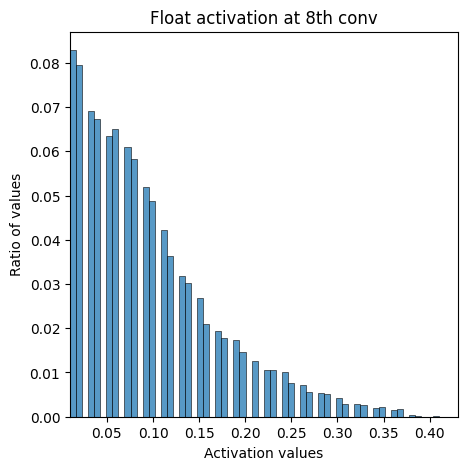

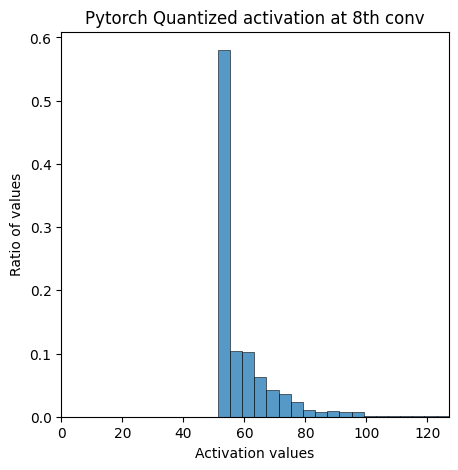

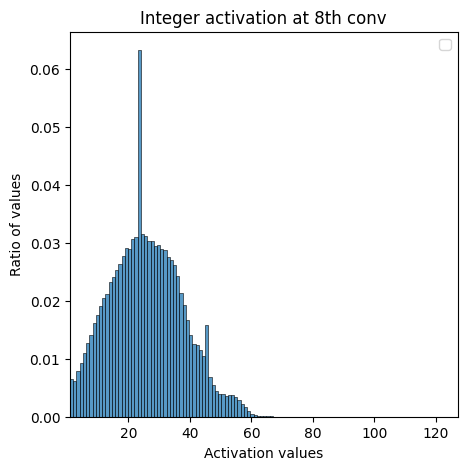

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
# print(len(torch_static_conv[i]))

for i in range(len(int_activation_after)):
    i = 7
    plt.figure(figsize=(5,5))
    # plt.subplot(1,3,1)
    a = np.round(np.array(float_activation[i][0].contiguous().view(-1).tolist()),2)
    a = [x for x in a if x!=0]
    sns.histplot(a, stat='probability',bins=64)
    # plt.plot(bins[:-1], hist, width=(bins[1]-bins[0]))
    # plt.hist(a,bins = 1000, histtype='step', density=True, label=f"torch conv{i}")
    m = torch.max(torch.abs(float_activation[i][0])).item()
    plt.ylabel("Ratio of values")
    plt.xlabel("Activation values")
    plt.xlim(0.01,m)
    # plt.ylim(0,1)
    plt.title(f"Float activation at {i+1}th conv")

    plt.figure(figsize=(5,5))
    # plt.subplot(1,3,2)
    # plt.hist((torch_quant_activation[i][0].int_repr().to(torch.int8)).contiguous().view(-1).tolist(), bins=127,  density=True, histtype='step', label=f"torch quant conv{i}")
    sns.histplot((torch_quant_activation[i][0].int_repr().to(torch.int8)).contiguous().view(-1).tolist(), stat='probability', bins= 64)
    plt.title(f"Pytorch Quantized activation at {i+1}th conv")
    plt.ylabel("Ratio of values")
    plt.xlabel("Activation values")
    plt.xlim(0,127)
    # plt.legend()
    # max_val = max(max_val, max(conv_weights[i]))
    # min_val = min(min_val, min(conv_weights[i]))
    
    plt.figure(figsize=(5,5))
    # plt.subplot(1,3,3)
    a = int_activation_after[i][0].contiguous().view(-1).tolist()
    a = [x for x in a if x!=0]
    # plt.hist(a, bins=len(range(1,127)), histtype='step',  density=True, label=f"integer conv{i}")
    sns.histplot(a, stat='probability', bins= 64)
    plt.title(f"Integer activation at {i+1}th conv")
    plt.ylabel("Ratio of values")
    plt.xlabel("Activation values")
    plt.xlim(1,127)
    # plt.axvline(0, color='black', linestyle='-', linewidth=1, zorder=0)
    plt.legend()
    plt.show()
    break

## Weight 변환이 잘 되었는 지 Plot

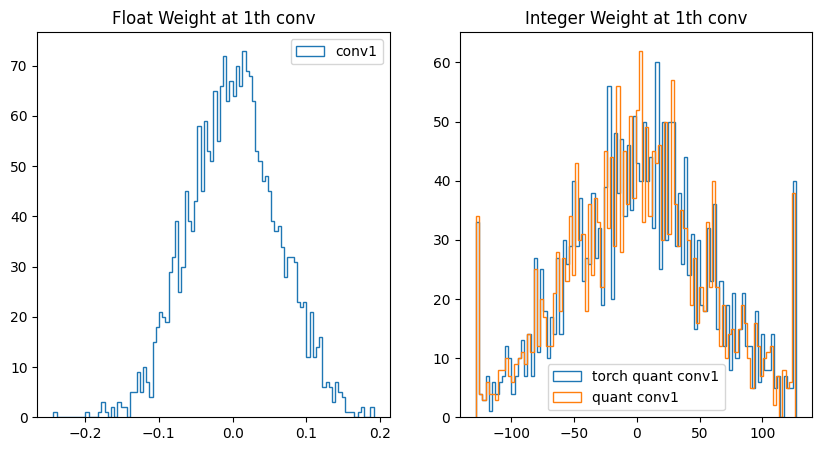

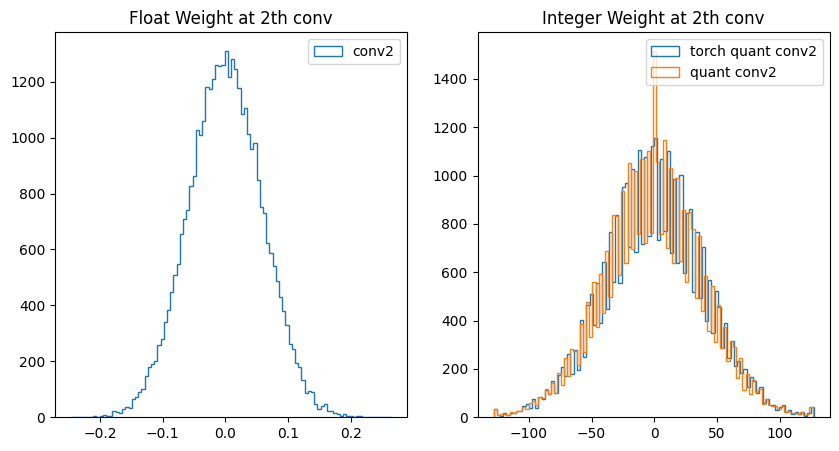

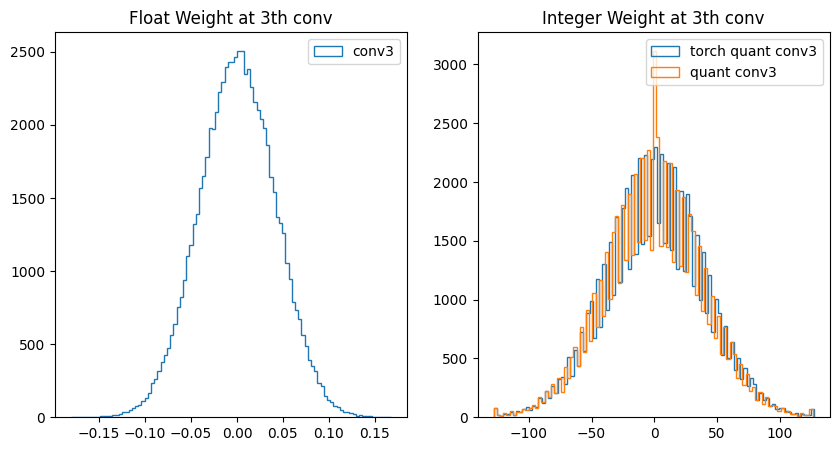

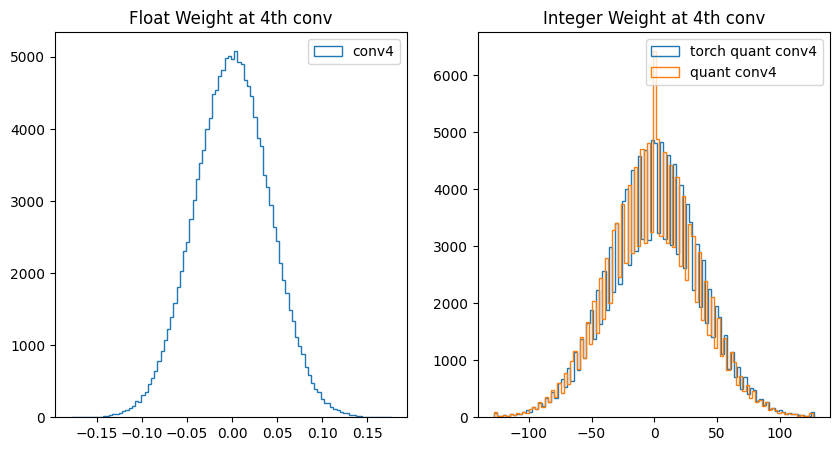

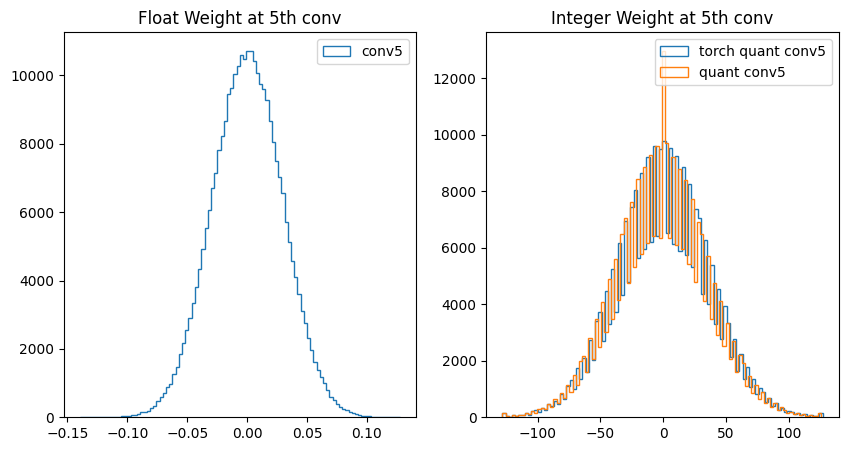

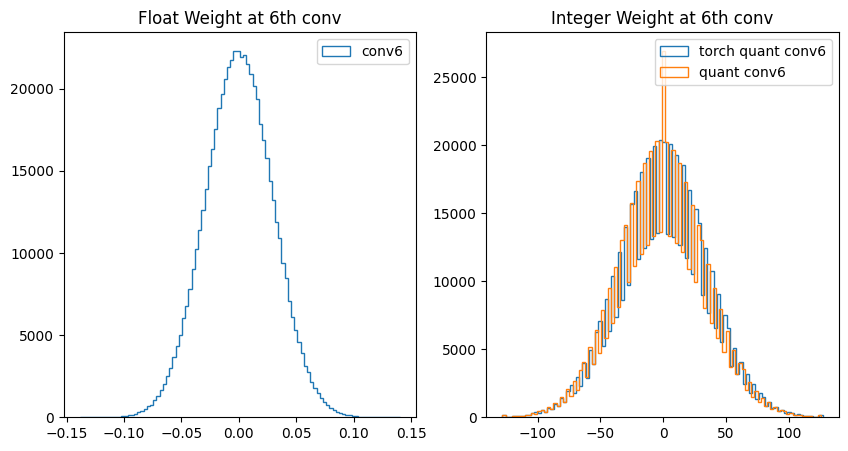

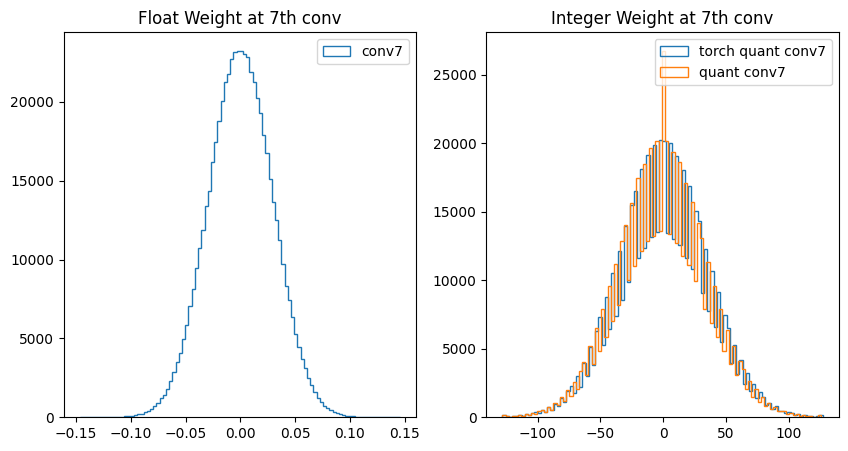

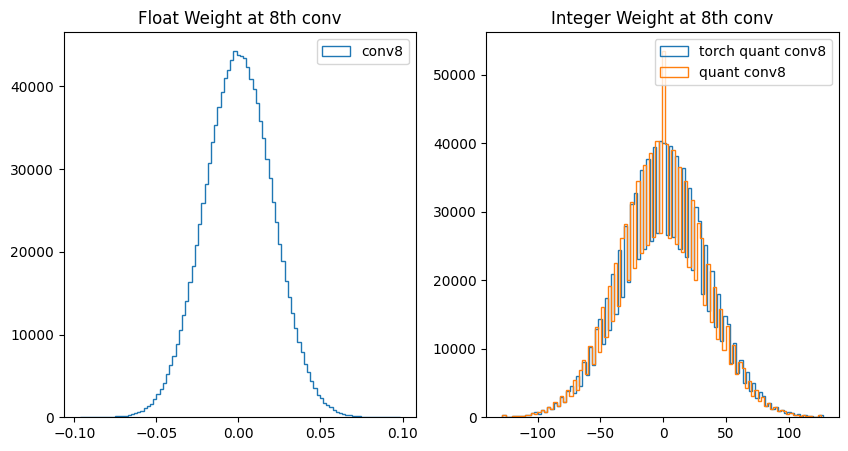

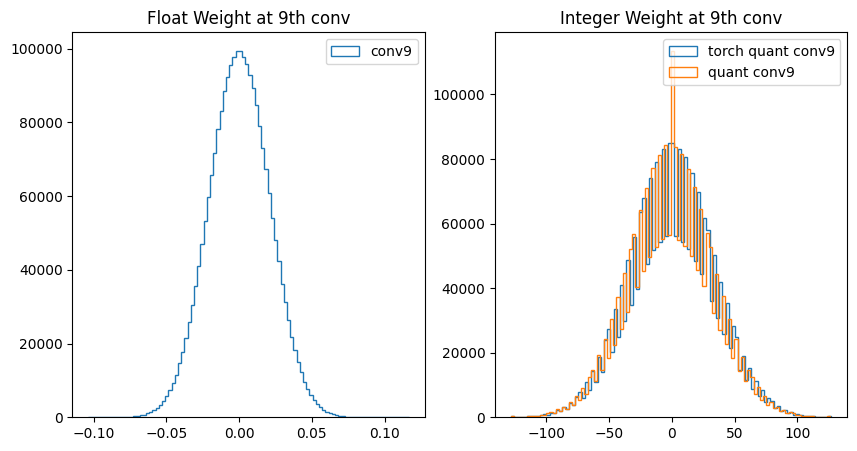

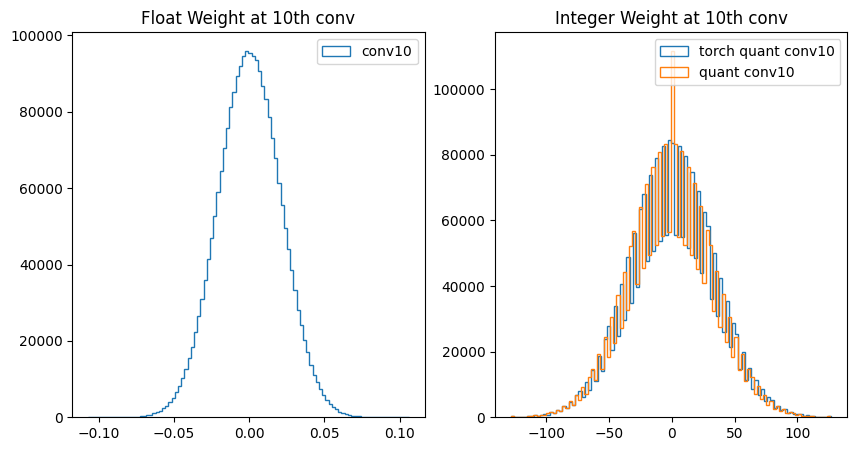

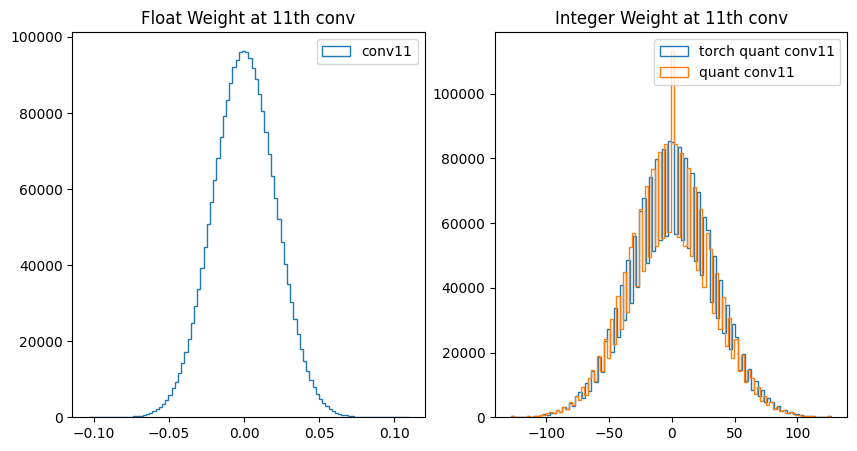

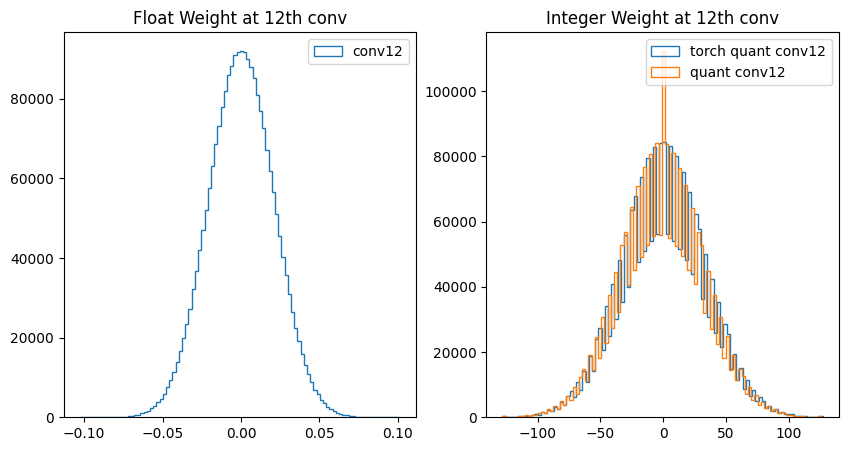

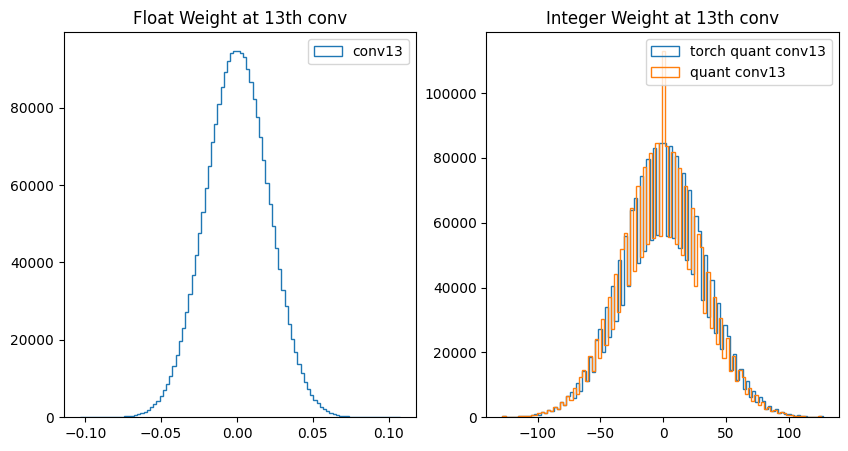

In [35]:
import matplotlib.pyplot as plt
max_val = 0
min_val = -10000
# print(len(torch_static_conv[i]))
for i in range(len(conv_weights)):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.hist(conv_weights[i], bins=100, histtype='step', label=f"conv{i+1}")
    # plt.axvline(1.0, 0.2, 0.8, color='lightgray', linestyle='--', linewidth=2)
    plt.legend()
    plt.title(f"Float Weight at {i+1}th conv")

    plt.subplot(1,2,2)
    plt.hist(torch_static_conv[i], bins=100, histtype='step', label=f"torch quant conv{i+1}")
    plt.hist(static_conv[i], bins=100, histtype='step', label=f"quant conv{i+1}")
    max_val = max(max_val, max(conv_weights[i]))
    min_val = min(min_val, min(conv_weights[i]))
    plt.title(f"Integer Weight at {i+1}th conv")
    plt.legend()
    plt.show()

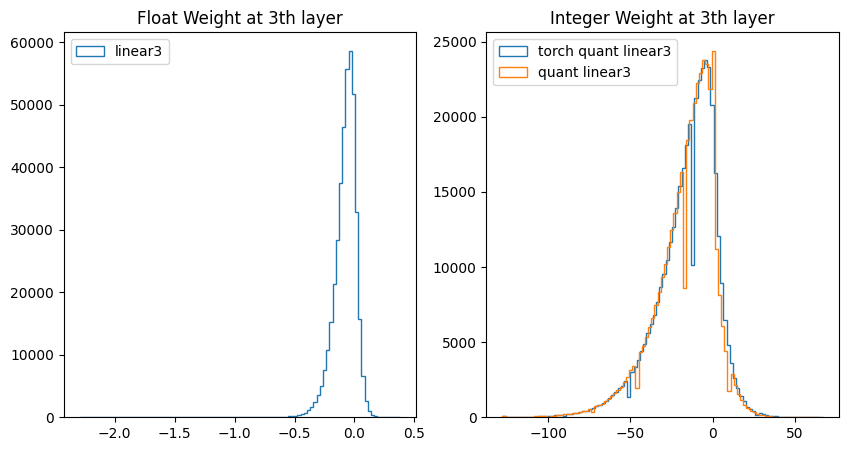

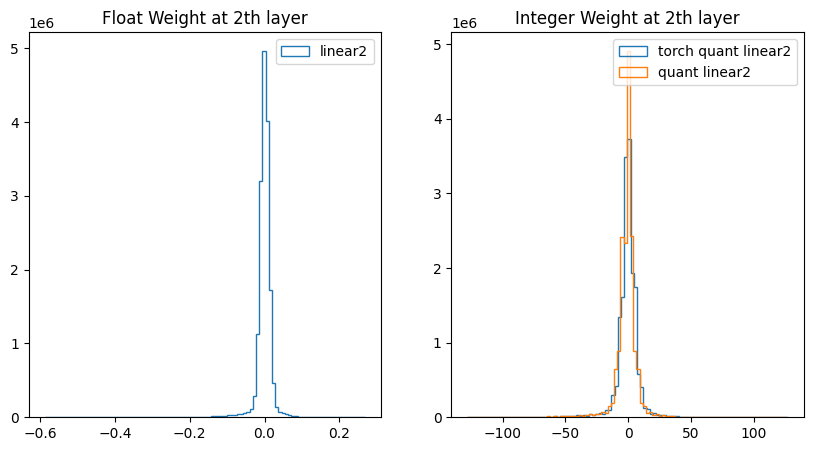

In [36]:
max_val = 0
min_val = -10000
# print(len(torch_static_conv[i]))
for i in range(len(linear_weights)-1,0,-1):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.hist(linear_weights[i], bins=100, histtype='step', label=f"linear{i+1}")
    plt.legend()
    plt.title(f"Float Weight at {i+1}th layer")

    plt.subplot(1,2,2)
    plt.hist(torch_static_linear[i], bins=100, histtype='step', label=f"torch quant linear{i+1}")
    plt.hist(static_linear[i], bins=100, histtype='step', label=f"quant linear{i+1}")
    max_val = max(max_val, max(linear_weights[i]))
    min_val = min(min_val, min(linear_weights[i]))
    plt.title(f"Integer Weight at {i+1}th layer")
    plt.legend()
    plt.show()